# LLM Iteration 29

**Aim**

To create a histogram of the model metrics from the results of the multiple_replications function.

**Prompt**

Create a plot_histogram function that uses the results of the multiple_replications function to plot histograms of the mean number of patients waiting, mean waiting time for a bed, throughput and mean time in system from each replication. The dataframe containing the results from the multiple_replications function should be passed to the function.

**Note**

Modifications have been made to the output from the LLM, indicated by:
```python
########## MODIFICATION ##########
change
##################################
```
This is either used to add in code from previous iterations if only certain sections were updated, used to correct the LLM's code if required, or used to check the model is working as expected.

**Additional code to run model**

In [1]:
def trace(msg):
    '''
    Utility function for printing simulation.
    Set the TRACE constant to FALSE to turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [2]:
TRACE = False

In [3]:
import simpy
import numpy as np
import math
import pandas as pd

In [4]:
class Scenario:
    def __init__(self, num_beds, run_length=60*2, seed=None):
        self.num_beds = num_beds
        self.run_length = run_length
        self.seed = seed
        self.default_interarrival_times = {
            "Stroke": 1.2,
            "TIA": 9.3,
            "Complex Neurological": 3.6,
            "Other": 3.2
        }
        self.random_seeds = {
            "Stroke": 12345,
            "TIA": 54321,
            "Complex Neurological": 98765,
            "Other": 67890
        }

    def create_distributions(self, num_runs):
        interarrival_distributions = {}
        seeds = self.generate_seeds(num_runs)
        for patient_type, seed in seeds.items():
            if seed[0] is not None:
                np.random.seed(seed)
                interarrival_distributions[patient_type] = np.random.\
                    default_rng(seed)
            else:
                interarrival_distributions[patient_type] = np.random.\
                    default_rng()
        return interarrival_distributions

    def generate_seeds(self, num_runs):
        seeds = {}
        for patient_type, seed in self.random_seeds.items():
            if self.seed is not None:
                seeds[patient_type] = [seed + i + self.seed for i in \
                                       range(num_runs)]
            else:
                seeds[patient_type] = [None for i in range(num_runs)]
        return seeds

In [5]:
class StrokeWard:
    def __init__(self, scenario):
        self.env = simpy.Environment()
        self.beds = simpy.Resource(self.env, capacity=scenario.num_beds)
        self.patient_count = 0
        self.wait_times = []
        self.waiting_patients = []
        self.length_of_stay = {
            "Stroke": {"mean": 7.4, "std_dev": 8.6},
            "TIA": {"mean": 1.8, "std_dev": 2.3},
            "Complex Neurological": {"mean": 4.0, "std_dev": 5.0},
            "Other": {"mean": 3.8, "std_dev": 5.2}
        }
        self.interarrival_distributions = scenario.\
            create_distributions(num_runs=1)
        self.route_probabilities = {
            "Stroke": {"ESD": 0.13, "Rehab Unit": 0.24, "Other": 0.63},
            "TIA": {"ESD": 0.01, "Rehab Unit": 0.01, "Other": 0.98},
            "Complex Neurological": {"ESD": 0.05, "Rehab Unit": 0.11,
                                     "Other": 0.84},
            "Other": {"ESD": 0.10, "Rehab Unit": 0.05, "Other": 0.85}
        }
        self.patients_in_beds = 0
        self.bed_in_use_store = []
        self.patient_type_store = []
        self.los_store = []

    def update_length_of_stay(self, patient_type, destination):
        if patient_type == 'Stroke':
            if destination == 'ESD':
                return {"mean": 4.6, "std_dev": 4.8}
            elif destination == 'Other':
                # Mortality rate for Stroke patients going to Other
                if np.random.rand() < 0.02:
                     # Adjusted parameters for mortality case
                    return {"mean": 7.0, "std_dev": 8.7}
        return self.length_of_stay[patient_type]

    def admit_patient(self, patient):
        arrival_time = round(self.env.now, 2)
        with self.beds.request() as bed:
            yield bed
            bed_arrival_time = self.env.now
            self.patients_in_beds += 1
            self.bed_in_use_store.append(self.patients_in_beds)
            self.patient_type_store.append(patient.patient_type)

            wait_time = max(0, round(self.env.now - arrival_time, 2))
            self.wait_times.append(wait_time)
            self.waiting_patients.append(len(self.beds.queue))

            trace(f'Patient {patient.id} ({patient.patient_type}) admitted '
                  f'to the stroke ward at day {round(self.env.now, 2)}. '
                  f'Wait time: {wait_time} days')

            route_probabilities = list(self.route_probabilities[patient.\
                                       patient_type].values())
            route_names = list(self.route_probabilities[patient.\
                               patient_type].keys())

            rng = np.random.default_rng(patient.seed)
            route_choice = rng.choice(route_names, p=route_probabilities)

            length_of_stay_params = self.update_length_of_stay(patient.\
                                                               patient_type,
                                                               route_choice)

            mu, sigma = calculate_mu_sigma(length_of_stay_params["mean"],
                                           length_of_stay_params["std_dev"])

            los = np.random.default_rng(patient.seed).lognormal(mu, sigma)
            yield self.env.timeout(round(los, 2))

            self.patients_in_beds -= 1
            bed_leave_time = self.env.now
            self.los_store.append(round(bed_leave_time - bed_arrival_time, 2))

            trace(f'Patient {patient.id} ({patient.patient_type}) discharged '
                  f'from the stroke ward at day {round(self.env.now, 2)}')

            trace(f'Patient {patient.id} ({patient.patient_type}) routed to: '
                  f'{route_choice}')

    def patient_arrival(self, patient_type):
        while True:
            if patient_type in self.interarrival_distributions:
                interarrival_time = self.\
                    interarrival_distributions[patient_type].exponential(
                        scenario.default_interarrival_times[patient_type])
                yield self.env.timeout(interarrival_time)
                patient = Patient(self.patient_count, patient_type,
                                  self.\
                                  interarrival_distributions[patient_type])
                self.patient_count += 1
                self.env.process(self.admit_patient(patient))

    def summary(self):
        mean_wait_time = round(np.mean(self.wait_times), 2)
        mean_waiting_patients = round(np.mean(self.waiting_patients), 2)

        summary_data = {
            'Mean Wait Time': [mean_wait_time],
            'Mean Waiting Patients': [mean_waiting_patients]
        }

        summary_df = pd.DataFrame(summary_data)

        return summary_df

In [6]:
class WarmupAuditor:
    def __init__(self, scenario, audit_interval):
        self.scenario = scenario
        self.audit_interval = audit_interval
        self.audit_times = []
        self.waiting_patients_audit = []
        self.wait_times_audit = []

    def run_model(self):
        stroke_ward = StrokeWard(self.scenario)
        env = stroke_ward.env

        PATIENTS = ["Stroke", "TIA", "Complex Neurological", "Other"]
        for patient_type in PATIENTS:
            env.process(stroke_ward.patient_arrival(patient_type))

        env.process(self.audit_model(stroke_ward))
        env.run(until=self.scenario.run_length)

        return self.summary()

    def audit_model(self, stroke_ward):
        while stroke_ward.env.now < self.scenario.run_length:
            yield stroke_ward.env.timeout(self.audit_interval)
            self.audit_times.append(stroke_ward.env.now)
            self.waiting_patients_audit.append(np.mean(stroke_ward.\
                                                       waiting_patients))
            self.wait_times_audit.append(np.mean(stroke_ward.wait_times))

    def summary(self):
        audit_data = {
            'Audit Time': self.audit_times,
            'Mean Waiting Patients': self.waiting_patients_audit,
            'Mean Wait Time': self.wait_times_audit
        }

        summary_df = pd.DataFrame(audit_data)

        return summary_df

In [7]:
def calculate_mu_sigma(mean, std_dev):
    v = std_dev ** 2
    m = mean
    phi = math.sqrt(v + m ** 2)
    mu = math.log((m ** 2) / phi)
    sigma = math.sqrt(math.log((phi ** 2) / (m ** 2)))
    return mu, sigma

class Patient:
    def __init__(self, id, patient_type, seed):
        self.id = id
        self.patient_type = patient_type
        self.seed = seed

In [8]:
def single_run(scenario):
    stroke_ward = StrokeWard(scenario)

    PATIENTS = ["Stroke", "TIA", "Complex Neurological", "Other"]
    for patient_type in PATIENTS:
        stroke_ward.env.process(stroke_ward.patient_arrival(patient_type))

    trace("Simulation started...")
    stroke_ward.env.run(until=scenario.run_length)
    trace("Simulation ended.")

    return stroke_ward

def multiple_replications(scenario, num_runs):
    results = []
    for i in range(num_runs):
        scenario_with_seeds = Scenario(scenario.num_beds,
                                       run_length=scenario.run_length,
                                       seed=scenario.seed)
        scenario_with_seeds.random_seeds = {k: v[i] for k, v in scenario.\
                                            generate_seeds(num_runs).items()}
        
        stroke_ward = single_run(scenario_with_seeds)
        result_summary = stroke_ward.summary()
        results.append(result_summary)

    df_results = pd.concat(results, keys=[f'Replication {i+1}' for i in \
                                          range(num_runs)])

    return df_results

In [9]:
def warmup_analysis(scenario, num_replications, audit_interval):
    waiting_patients_results = {}
    wait_times_results = {}

    for i in range(num_replications):
        scenario_with_seeds = Scenario(scenario.num_beds, scenario.run_length,
                                       seed=scenario.seed)
        scenario_with_seeds.random_seeds = {k: v[i] for k, v in scenario.\
                                            generate_seeds(num_replications).\
                                            items()}

        warmup_auditor = WarmupAuditor(scenario_with_seeds, audit_interval)
        audit_results = warmup_auditor.run_model()

        waiting_patients_results[f'Replication {i+1}'] = audit_results\
            ['Mean Waiting Patients']
        wait_times_results[f'Replication {i+1}'] = audit_results\
            ['Mean Wait Time']

    waiting_patients_df = pd.DataFrame(waiting_patients_results)
    wait_times_df = pd.DataFrame(wait_times_results)

    waiting_patients_df = waiting_patients_df.set_index(audit_results\
                                                        ['Audit Time'])
    wait_times_df = wait_times_df.set_index(audit_results['Audit Time'])

    results = {
        'Waiting Patients': waiting_patients_df,
        'Wait Times': wait_times_df
    }

    return results

In [10]:
def time_series_inspection(results, steady_state_time=None):
    waiting_patients_df = results['Waiting Patients']
    wait_times_df = results['Wait Times']

    audit_times_days = waiting_patients_df.index.values

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot mean number of patients waiting
    ax1.plot(audit_times_days, waiting_patients_df.mean(axis=1))
    ax1.set_title('Mean Number of Patients Waiting')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Number of Patients')

    if steady_state_time is not None:
        ax1.axvline(steady_state_time, color='r', linestyle='--',
                    label='Steady State')
        ax1.legend()

    # Plot mean bed waiting time
    ax2.plot(audit_times_days, wait_times_df.mean(axis=1))
    ax2.set_title('Mean Bed Waiting Time')
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Waiting Time (days)')

    if steady_state_time is not None:
        ax2.axvline(steady_state_time, color='r', linestyle='--',
                    label='Steady State')
        ax2.legend()

    plt.tight_layout()
    plt.show()

**LLM Output**

To create a plot_histogram function that uses the results of the multiple_replications function to plot histograms of the mean number of patients waiting, mean waiting time for a bed, throughput, and mean time in the system from each replication, you can use the following code:

In [11]:
# Example usage:
import matplotlib.pyplot as plt

In [12]:
def plot_histogram(results_df):
    #fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    axs = axs.flatten()

    # Mean number of patients waiting
    axs[0].hist(results_df['Mean Waiting Patients'], bins=20,
                edgecolor='black')
    axs[0].set_title('Mean Number of Patients Waiting')
    axs[0].set_xlabel('Number of Patients')
    axs[0].set_ylabel('Frequency')

    # Mean waiting time for a bed
    axs[1].hist(results_df['Mean Wait Time'], bins=20, edgecolor='black')
    axs[1].set_title('Mean Waiting Time for a Bed')
    axs[1].set_xlabel('Waiting Time (days)')
    axs[1].set_ylabel('Frequency')

    # Throughput
    #throughput = results_df['Patients Discharged'] / \
    #    (scenario.run_length / (24 * 60))  # Patients per day
    #axs[2].hist(throughput, bins=20, edgecolor='black')
    #axs[2].set_title('Throughput')
    #axs[2].set_xlabel('Patients per Day')
    #axs[2].set_ylabel('Frequency')

    # Mean time in system
    #time_in_system = results_df['Total Time in System'] / \
    #    results_df['Patients Discharged']
    #axs[3].hist(time_in_system, bins=20, edgecolor='black')
    #axs[3].set_title('Mean Time in System')
    #axs[3].set_xlabel('Time (days)')
    #axs[3].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

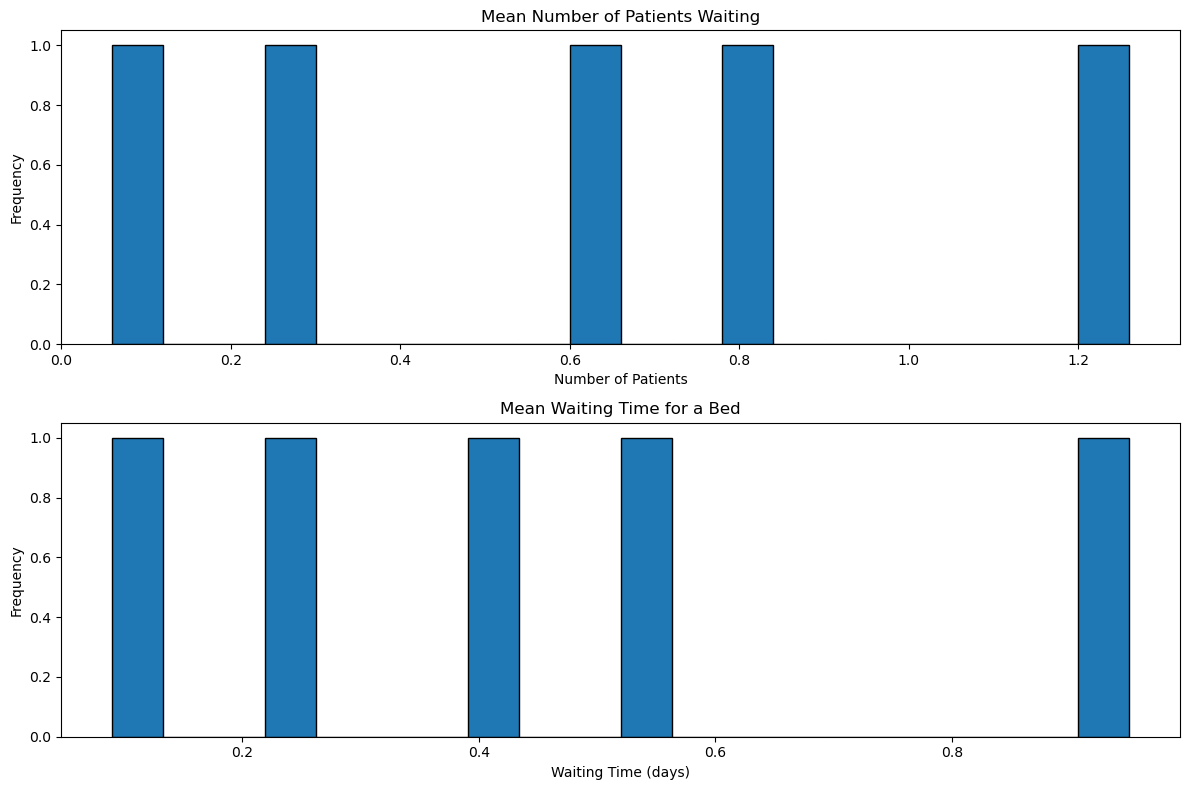

In [13]:
# Example usage:
scenario = Scenario(num_beds=10)
num_replications = 5
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

In this code:
- The plot_histogram function takes a DataFrame results_df as input, which is the output of the multiple_replications function.
- A figure with 2 rows and 2 columns of subplots is created using plt.subplots.
The subplots are flattened into a 1D array axs for easier access.
- In the first subplot (axs), a histogram of the 'Mean Waiting Patients' column from results_df is plotted using plt.hist.
- In the second subplot (axs), a histogram of the 'Mean Wait Time' column from results_df is plotted.
- In the third subplot (axs), a histogram of the throughput (patients discharged per day) is plotted. The throughput is calculated by dividing the 'Patients Discharged' column by the run length in days.
- In the fourth subplot (axs), a histogram of the mean time in the system is plotted. The mean time in the system is calculated by dividing the 'Total Time in System' column by the 'Patients Discharged' column.
- Appropriate titles and labels are added to each subplot.
- The plt.tight_layout() function is called to ensure proper spacing between the subplots.
- The plt.show() function is called to display the plot.
- In the example usage, a Scenario instance is created, and the multiple_replications function is called to obtain the results DataFrame. The plot_histogram function is then called with the results DataFrame to generate the histograms.

This implementation allows you to visualize the distributions of the mean number of patients waiting, mean waiting time for a bed, throughput, and mean time in the system across multiple replications using histograms. These histograms can provide insights into the variability and central tendencies of these performance measures, aiding in the analysis and interpretation of the simulation results.

**Checks**

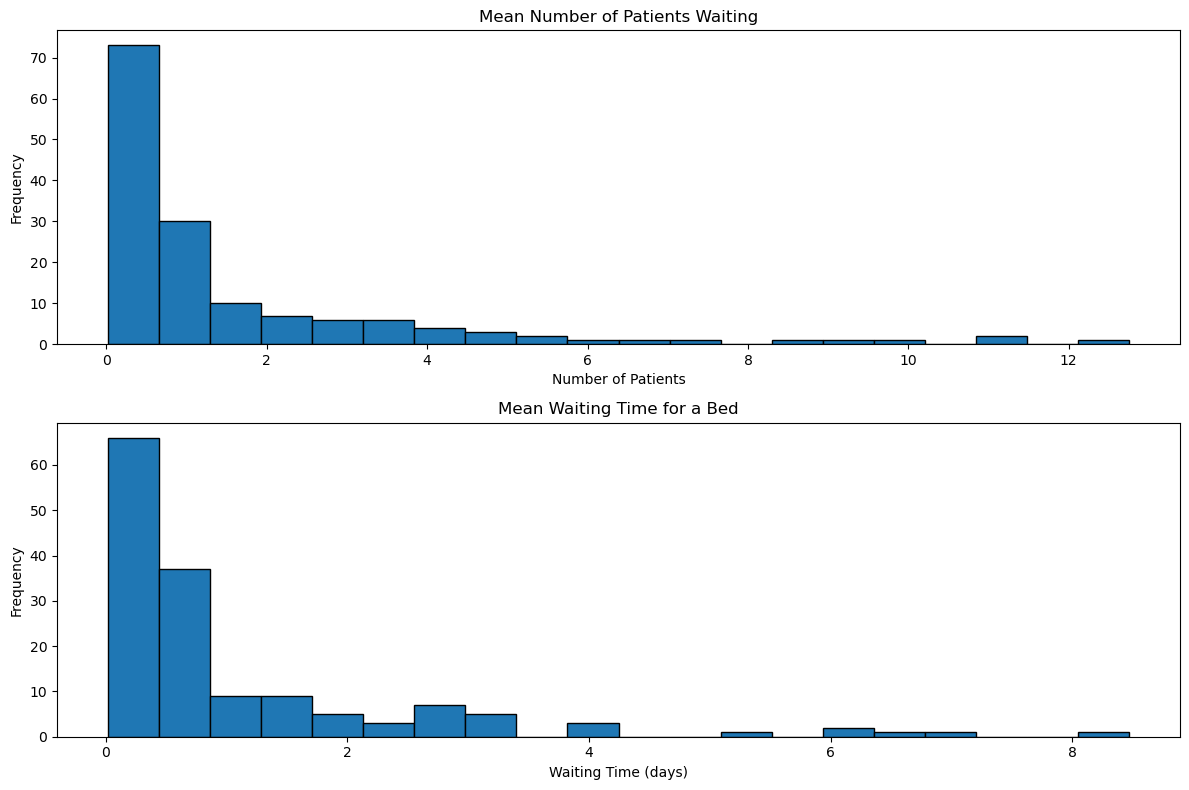

In [14]:
# Changing number of replications
scenario = Scenario(num_beds=10)
num_replications = 150
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

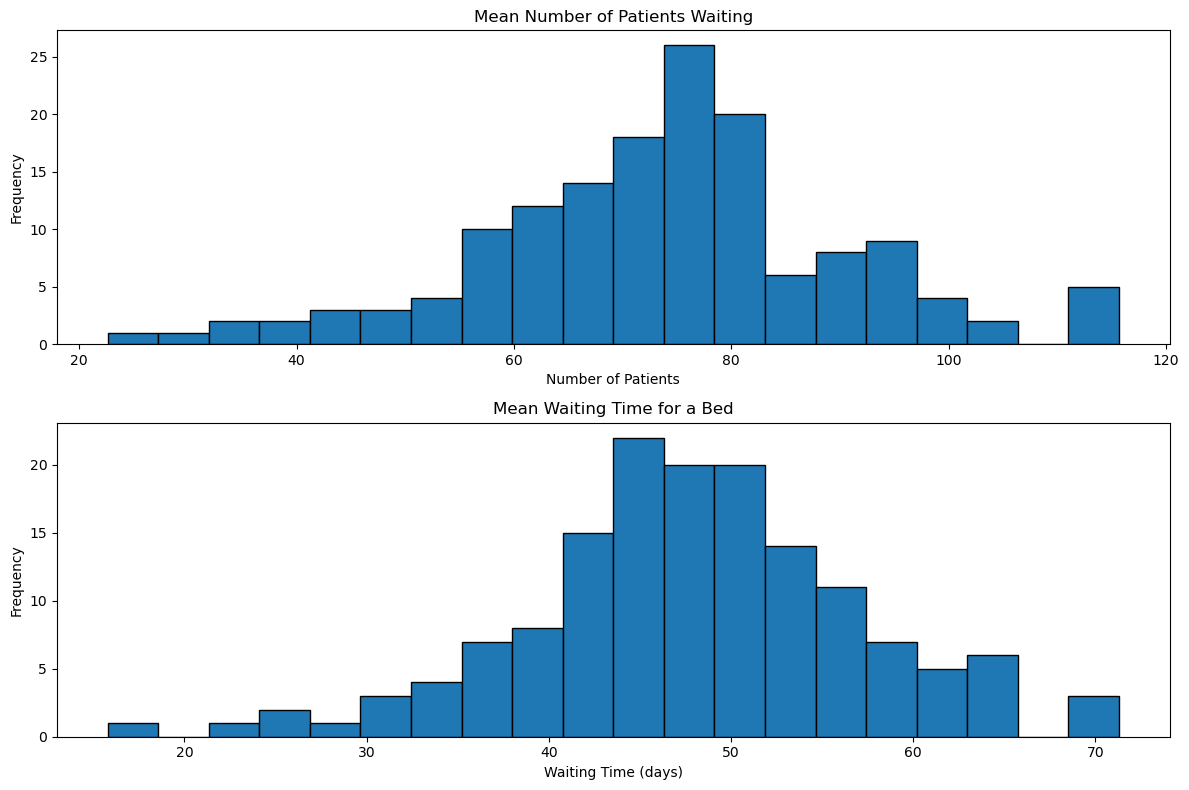

In [15]:
# Changing the number of beds
scenario = Scenario(num_beds=1)
num_replications = 150
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

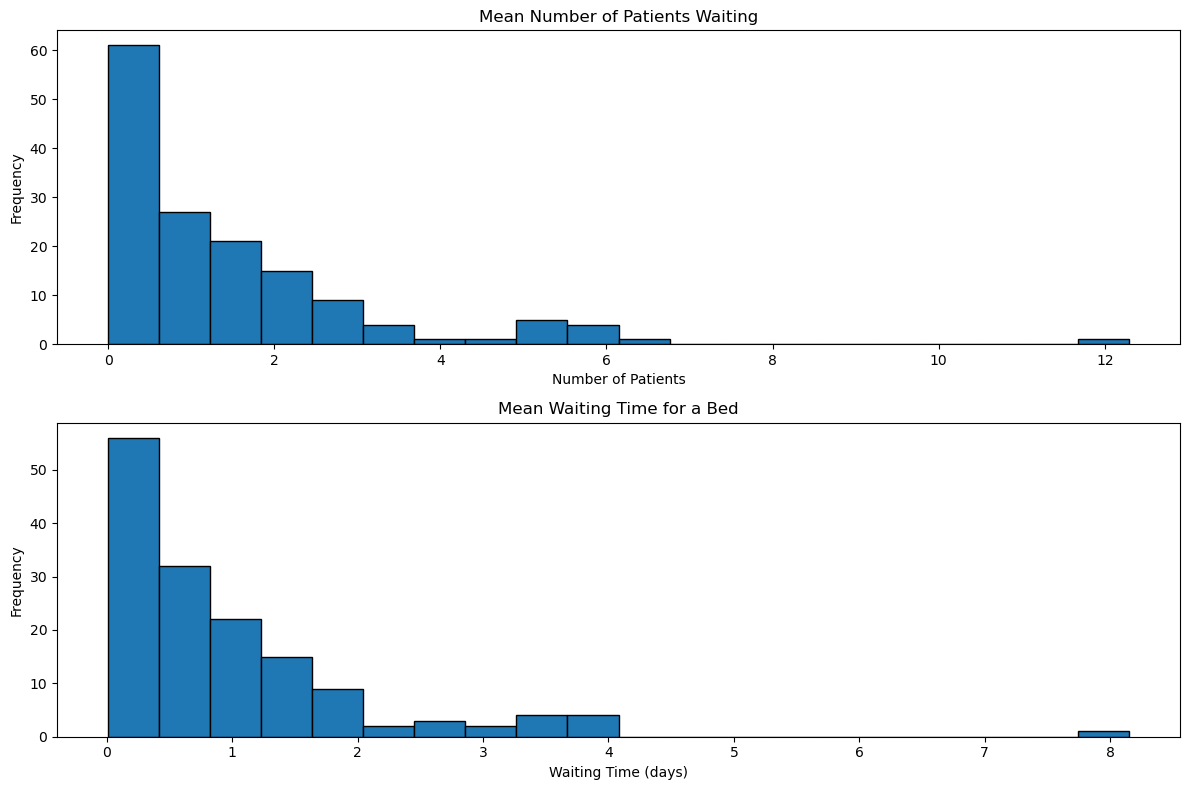

In [16]:
# Changing the random seed
scenario = Scenario(num_beds=10, seed=1)
num_replications = 150
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

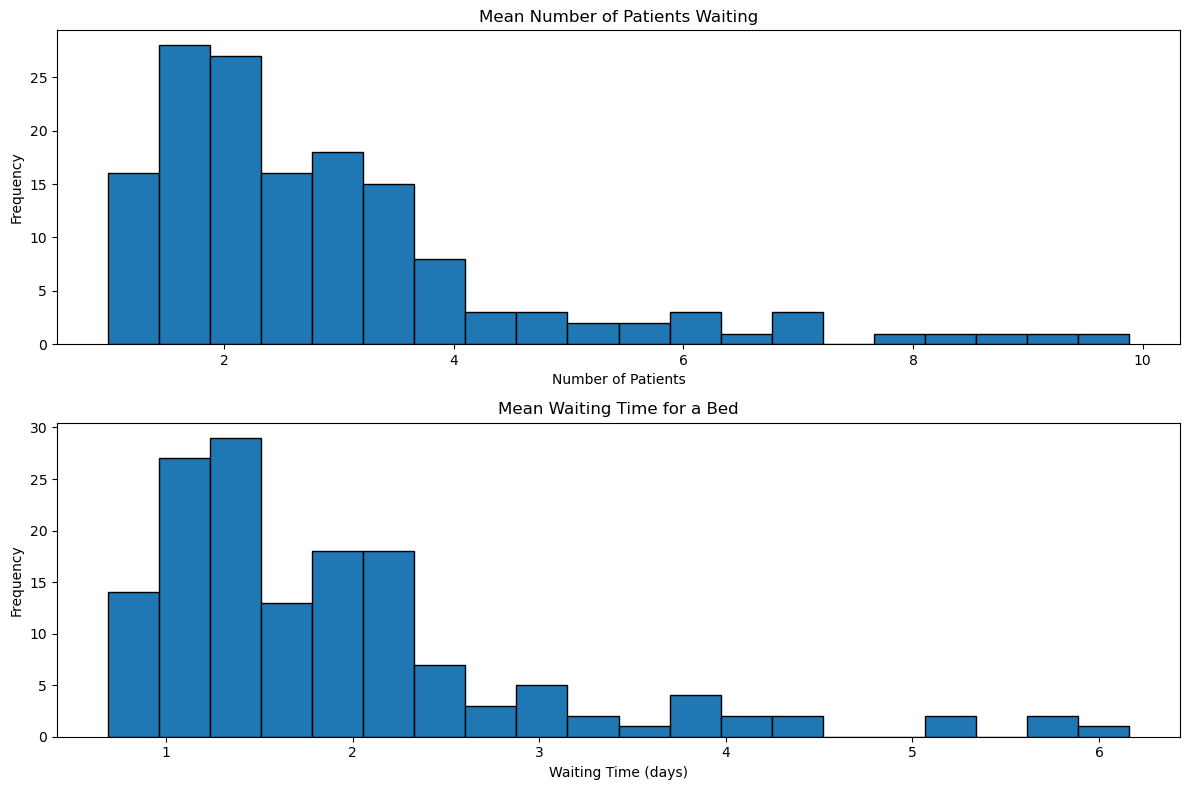

In [17]:
# Changing the run length
scenario = Scenario(num_beds=10, run_length=1800)
num_replications = 150
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

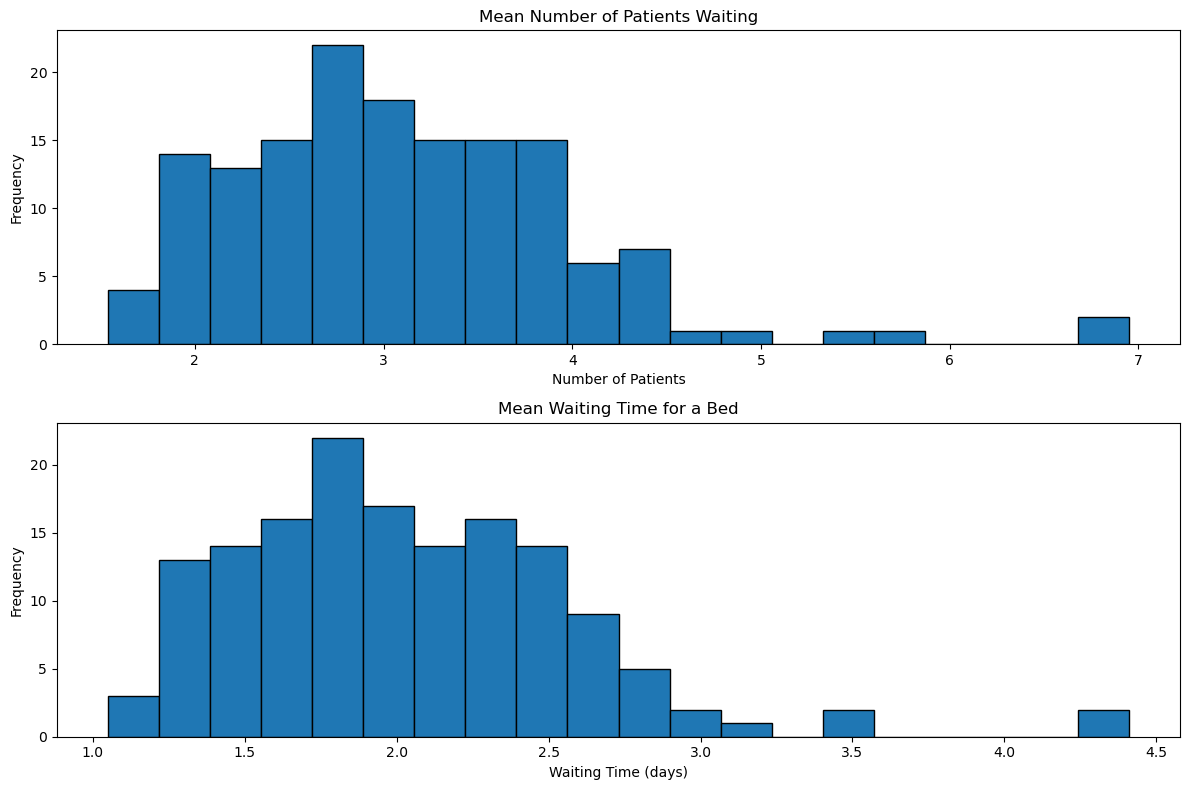

In [18]:
# Changing the run length
scenario = Scenario(num_beds=10, run_length=6000)
num_replications = 150
final_results = multiple_replications(scenario, num_replications)
plot_histogram(final_results)

**Reflection**

The LLM has implemented a function to plot the results of the multiple replications function. It attempted to implement all parts asked for in the prompt, but as it did not collect the number of patients discharged and total time in system, these parts could not be plot as they were not in the summary dataframe. It also interpreted throughput as number of patients per day in the system as opposed to total number of patients that passed through the system. Changing the number of beds changes the distribution as expected. A longer run-time than suggested is needed to reach a steady state as shown by the warm-up analysis in iteration 28, which takes a while to run. There is no option to start collecting data after a certain period of time.